This script is to produce the results for the numerical experiments of section 4.1 in the main paper: 
$$ F(\mathbf x) = \mathbb E_\zeta f(\mathbf x, \zeta), \qquad f(\mathbf x, \zeta) := \sum_{i=1}^d \frac{i}{2}x_i^2 (1 + z_{1,i}) + \mathbf x^\top \mathbf z_2. $$

In [15]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import pandas as pd

In [17]:
class arguments:
    T = 1000
    
    mu = 1.0
    L = 3.0
    kappa = L/mu

    d = 3
    N = 20
    
    x0 = 1.0

    A_np = np.diag(np.arange(1,d+1))
    A = torch.diag(torch.tensor((np.arange(1,d+1)).astype(np.float32)))
    print(f"A:{A}")

    c = 1.0
    sigma = .5
    
    beta = 1
    
    reps = 100
    plot_every = 50
    print_every = reps/10

arg = arguments()

A:tensor([[1., 0., 0.],
        [0., 2., 0.],
        [0., 0., 3.]])


In [18]:
def F(x, arg, stochastic = True, normal=True):
    if stochastic:
        if normal:
            z1 = arg.c*torch.randn_like(x)
            z2 = arg.sigma*torch.randn_like(x)
        else: # laplace distribution
            z1 = torch.tensor(np.random.laplace(scale=arg.c, size=x.shape).astype(np.float32))
            z2 = torch.tensor(np.random.laplace(scale=arg.sigma, size=x.shape).astype(np.float32))
    else:
        z1 = 0
        z2 = 0

    output = 0.5*x*torch.matmul(arg.A,x)*(1 + z1) + z2*x
    return torch.sum(output, 0)

In [19]:
def F_np(x, arg, stochastic = True):
    # same as F, uses numpy arrays instead of torch.tensor
    if stochastic:
        z1 = arg.c*np.random.standard_normal(np.shape(x))
        z2 = arg.sigma*np.random.standard_normal(np.shape(x))
    else:
        z1 = 0
        z2 = 0

    output = 0.5*x*np.matmul(arg.A_np,x)*(1 + z1) + z2*x
#     print(output)
    return np.sum(output, 0)

In [20]:
def g(x, arg, stochastic=True):
    if stochastic:
        z1 = arg.c*np.random.standard_normal(np.shape(x))
        z2 = arg.sigma*np.random.standard_normal(np.shape(x))
    else:
        z1 = 0
        z2 = 0
        
    return np.matmul(arg.A_np,x)*(1 + z1) + z2

In [21]:
with torch.no_grad():
    loss_0 = F(arg.x0*torch.ones((arg.d,1)), arg, stochastic=False).item()
    print(loss_0)

3.0


## calculate parameters for FedAC

In [22]:
def get_params_ac_1(arg, R=None, eta=None, N=None, T=None):
    if not T:
        T = arg.T
        
    if not N:
        N = arg.N
        
    if not R:
        R = np.ceil(arg.N**(1/2))
        
    phi0 = loss_0 + (arg.mu/2)*arg.d*(arg.x0**2)
        
    H = arg.T/R
    
    if not eta:
        c = np.log(np.e + min(arg.mu*N*T*phi0/(arg.sigma**2),
                               (arg.mu**2)*(T**3)*phi0/((arg.L)*(H**2)*(arg.sigma**2))))**2
#         print(f'c: {c}')
        eta = min(1/arg.L, 1/(arg.mu*arg.T*R)*c)
    
    gamma = max(np.sqrt(eta/(arg.mu*H)), eta)
    alpha = 1/(gamma*arg.mu)
    beta = alpha + 1
    
    return eta, gamma, alpha, beta, phi0

get_params_ac_1(arg)

(0.028409693163223712,
 0.028409693163223712,
 35.199253798858265,
 36.199253798858265,
 4.5)

In [23]:
def get_params_ac_2(arg, R=None, eta=None, N=None, T=None):
    if not T:
        T = arg.T
        
    if not N:
        N = arg.N
        
    if not R:
        R = np.ceil(arg.N**(1/3))
        
    phi0 = loss_0 + (arg.mu/6)*arg.d*(arg.x0**2)
        
    H = arg.T/R
    
    if not eta:
        c = np.log(np.e + min(arg.mu*N*T*phi0/(arg.sigma**2),
                               (arg.mu**3)*(T**4)*phi0/((arg.L**2)*(H**3)*(arg.sigma**2))))**2
#         print(f'c: {c}')
        eta = min(1/arg.L, 9/(arg.mu*arg.T*R)*c)
    
    gamma = max(np.sqrt(eta/(arg.mu*H)), eta)
    alpha = 1.5/(gamma*arg.mu) - 0.5
    beta = (2*(alpha**2)-1)/(alpha - 1)
    
    return eta, gamma, alpha, beta, phi0

get_params_ac_2(arg)

(0.3333333333333333, 0.3333333333333333, 4.0, 10.333333333333334, 3.5)

In [24]:
## generate communication times for different strategies
plot_labels = {
    0:r'Synchronous SGD',
    1:r'[Sti19]',
    2:'[HKMC19]',
    3:'$H_i = a(i+1)$ [This Paper]',
    4: r'$H = T/N$',
    5:r'$H=T$ (OSA)',
    6: r'FedAC-I, $R=N^{1/2}$',
    7: r'FedAC-II, $R=N^{1/3}$',
}

def get_comms(method, arg, N=None, T=None):
    if not N:
        N = arg.N
        T = arg.T
    
    if method == 0:
        comms = np.arange(T+1)
        print('synchronous')
        
    elif method == 1:
        H = int(np.sqrt(T/N))
        print(f"H={H}")
        
        comms = [H*t for t in range(T//H + 1)]
        plot_labels[method] = r'$H=%d$ [Sti19]' %H

    elif method == 2:
        H = int(((T**2)/N)**(1/3))
        print(f"H={H}")
        comms = [H*t for t in range(T//H + 1)]
        
        plot_labels[method] = r'$H=%d$ [HKMC19]' %H
        
    elif method == 3: # This Paper
        R = N 
        a = 2*T/(R*(R+1))
        print(f"R:{R}, a:{a}")
        plot_labels[method] = r'$H_i~%d(i+1)$ (This Paper)' % int(a)
        
        comms = [int(a*r*(r+1)/2) for r in range(R+1)]

    elif method == 4:
        R = N 
        H = arg.T/R
        print(f"H={H}")
        comms = [int(np.ceil(H*r)) for r in range(R+1) if H*r <= T]
        plot_labels[method] = r'$H=%d~(T/N)$' %H

    elif method == 5:
        comms = [0,T]
        print(r'H=T (OSA)')
        
    elif method == 6:
        R = int(np.ceil(N**(1/2)))
        H = T/R
        comms = [int(H*r) for r in range(R+1)]
        print('FedAC-I')
        
    elif method == 7:
        R = int(np.ceil(N**(1/3)))
        H = T/R
        comms = [int(H*r) for r in range(R+1)]
        print('FedAC-II')

    if comms[-1] != T:
        comms.append(T)
        
    comms = np.array(comms, dtype = int)
    return comms

In [25]:
def train_dist(comms, arg):
    comm_error_sum = np.zeros(len(comms))
    iter_error_sum = np.zeros(np.ceil(arg.T/arg.plot_every + 1).astype(int))
    iter_error2_sum = np.zeros(np.ceil(arg.T/arg.plot_every + 1).astype(int))
    
    
    for rep in range(arg.reps):

        X = torch.tensor(arg.x0*np.ones((arg.d,arg.N), dtype=np.float32),requires_grad = True)
        optimizer = optim.SGD([X], lr=1.0)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: 3/(arg.mu*(t+arg.beta)), last_epoch=-1)
        
        comm_error = [loss_0]
        iter_error = [loss_0]
        for t in range(arg.T):
            optimizer.zero_grad()
            loss = F(X, arg).sum()

            loss.backward()
            optimizer.step()
            scheduler.step()
            
            if (t+1) in comms: # calculating the average of workers' parameters
                x_avg = torch.mean(X.data, dim = 1).unsqueeze(1)
                X.data = torch.ones_like(X)*x_avg
                
                with torch.no_grad():
                    actual_loss = F(x_avg, arg, stochastic=False).item()
                
                comm_error.append(actual_loss)


            if (t+1) % arg.plot_every == 0  or (t+1)==arg.T:
                x_avg = torch.mean(X.data, dim = 1).unsqueeze(1)
                with torch.no_grad():
                    actual_loss = F(x_avg, arg, stochastic=False).item()
                iter_error.append(actual_loss)


        comm_error_sum += np.array(comm_error)
        iter_error_sum += np.array(iter_error)
        iter_error2_sum += np.array(iter_error)**2
        
        if (rep+1) % arg.print_every == 0:
#             print('Simulation: %d/%d'%(rep+1, arg.reps))
                print('.', end='')
    print('')
    
    comm_error_avg = comm_error_sum/arg.reps
    iter_error_avg = iter_error_sum/arg.reps
    iter_error2_avg = iter_error2_sum/arg.reps
    
    return {'comm_error_avg': comm_error_avg, 'iter_error_avg': iter_error_avg, 'iter_error2_avg': iter_error2_avg}

In [26]:
def train_dist_AC(comms, arg, mode):
    comm_error_sum = np.zeros(len(comms))
    iter_error_sum = np.zeros(np.ceil(arg.T/arg.plot_every + 1).astype(int))
    iter_error2_sum = np.zeros(np.ceil(arg.T/arg.plot_every + 1).astype(int))
    
    phi_error_sum = np.zeros(np.ceil(arg.T/arg.plot_every + 1).astype(int)) # Potential Function defined only for FedAC
    
    # calculate FedAC parameters
    R = len(comms) - 1
    if mode == 1:
        eta, gamma, alpha, beta, phi0 = get_params_ac_1(arg, R)
    elif mode == 2:
        eta, gamma, alpha, beta, phi0 = get_params_ac_2(arg, R)
    else:
        raise ValueError
    
    for rep in range(arg.reps):

        W = arg.x0*np.ones((arg.d,arg.N))
        W_md = arg.x0*np.ones((arg.d,arg.N))
        W_ag = arg.x0*np.ones((arg.d,arg.N))
        
        V = np.zeros((arg.d,arg.N))
        V_ag = np.zeros((arg.d,arg.N))
        
        
        comm_error = [loss_0]
        iter_error = [loss_0]
        phi_error = [phi0]
        
        for t in range(arg.T):
            W_md = W/beta + (1 - 1/beta)*W_ag
            G = g(W_md, arg)
            V_ag = W_md - eta*G
            V = (1 - 1/alpha)*W + W_md/alpha - gamma*G
            
            if (t+1) in comms: # calculating the average of workers' parameters
                v_mean = V.mean(axis=1).reshape(-1,1)
                W = v_mean*np.ones((arg.d,arg.N))
                
                v_ag_mean = V_ag.mean(axis=1).reshape(-1,1)
                W_ag = v_ag_mean*np.ones((arg.d,arg.N))
                
                error = F_np(v_mean, arg, stochastic=False).item()
                
                comm_error.append(error)
            
            else:
                W = V
                W_ag = V_ag


            if (t+1) % arg.plot_every == 0  or (t+1)==arg.T:
                v_mean = V.mean(axis=1).reshape(-1,1)
                error = F_np(v_mean, arg, stochastic=False).item()
                iter_error.append(error)
                
                if mode == 1:
                    phi = F_np(W_ag, arg, False).mean() + 0.5*arg.mu*(np.linalg.norm(W.mean(axis=1).reshape(-1,1))**2)
                elif mode == 2:
                    phi = F_np(W_ag.mean(axis=1).reshape(-1,1), arg, False).item() + (1/6)*arg.mu*(np.linalg.norm(W.mean(axis=1).reshape(-1,1))**2)
                else:
                    raise ValueError
                phi_error.append(phi)
                


        comm_error_sum += np.array(comm_error)
        iter_error_sum += np.array(iter_error)
        iter_error2_sum += np.array(iter_error)**2
        
        phi_error_sum += np.array(phi_error)
        
        if (rep+1) % arg.print_every == 0:
#             print('Simulation: %d/%d'%(rep+1, arg.reps))
                print('.', end='')
    print('')
    
    comm_error_avg = comm_error_sum/arg.reps
    iter_error_avg = iter_error_sum/arg.reps
    iter_error2_avg = iter_error2_sum/arg.reps
    phi_error_avg = phi_error_sum/arg.reps
    
    return {
        'comm_error_avg': comm_error_avg,
        'iter_error_avg': iter_error_avg,
        'iter_error2_avg': iter_error2_avg,
        'phi_error_avg': phi_error_avg,
    }

method 6
FedAC-I
# of comms: 5
..........
method 7
FedAC-II
# of comms: 3
..........
method 3
R:20, a:4.761904761904762
# of comms: 20
..........
method 5
H=T (OSA)
# of comms: 1
..........


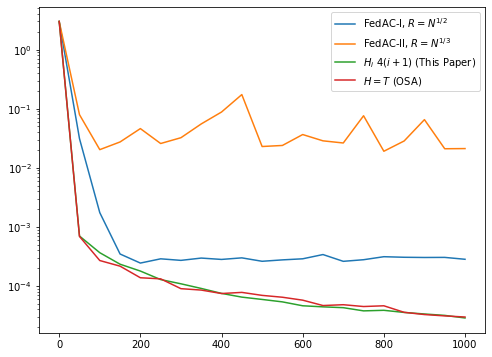

In [27]:
iter_avg_dict = {}
iter_std_dict = {}
comm_dict = {}

phi_dict = {}
plt.figure(figsize= (8,6))

methods = [6,7,3,5] #[0,1,2,3,4,5,6]
for method in methods:
    print('method %d'% method)
    comms = get_comms(method, arg)
    print('# of comms: %d' % (len(comms)-1))
    
    if method == 6:
        result = train_dist_AC(comms, arg, mode=1)
        phi_dict[method] = result['phi_error_avg']
    elif method == 7:
        result = train_dist_AC(comms, arg, mode=2)
        phi_dict[method] = result['phi_error_avg']
    else:
        result = train_dist(comms, arg)
    
    comm_dict[method] = result['comm_error_avg']
    iter_avg_dict[method] = result['iter_error_avg']
    iter_std_dict[method] = np.sqrt(result['iter_error2_avg'] - result['iter_error_avg']**2)/np.sqrt(arg.reps)
    
    
#     plt.fill_between(plot_every*np.arange(len(iter_error_avg)), iter_error_avg - iter_std, iter_error_avg + iter_std, alpha = 0.3)
    plt.plot(arg.plot_every*np.arange(len(result['iter_error_avg'])), result['iter_error_avg'], '-', label = plot_labels[method])
#     print('------')
    
plt.yscale('log')
plt.legend()
plt.show()

## $\phi$, $\Psi$

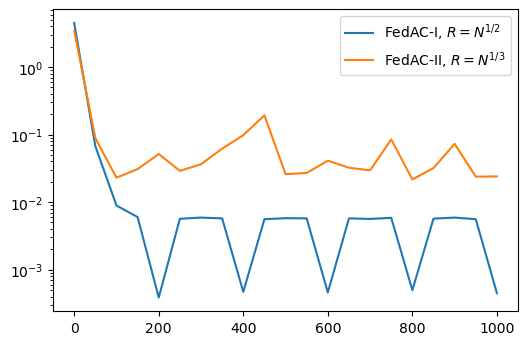

In [29]:
plt.figure(figsize=(6,4), dpi=100)
for method in [6,7]:
    plt.plot(arg.plot_every*np.arange(len(phi_dict[method])), phi_dict[method], '-', label = plot_labels[method])
    
    
# plt.gca().set_prop_cycle(None)

# # FedAC-I theoretical bound:
# phi0 = loss_0 + (arg.mu/2)*arg.d*(arg.x0**2)
# R = int(np.ceil(arg.N**(1/2)))
# H = arg.T/R


# PSI = [phi0] + [min(np.exp(-arg.mu*t/arg.L), np.exp(- np.sqrt(arg.mu/(arg.L*H))*t))*phi0 + \
#  2*(arg.sigma**2)/(arg.mu*arg.N*t)*(np.log(np.e + arg.mu*arg.N*t*phi0/(arg.sigma**2))**2) + \
#  400*arg.L*(H**2)*(arg.sigma**2)/((arg.mu**2)*(t**3))*np.log(np.e + (arg.mu**2)*(t**3)*phi0/(arg.L*(H**2)*(arg.sigma**2)))
#  for t in range(1,len(phi_dict[6]))]

# plt.plot(arg.plot_every*np.arange(len(PSI)), PSI, '--', label=r'$\Psi$  FedAC-I')

# # FedAC-II theoretical bound:
# phi0 = loss_0 + (arg.mu/6)*arg.d*(arg.x0**2)
# R = int(np.ceil(arg.N**(1/3)))
# H = arg.T/R

# PHI = [phi0] + [
#     min(np.exp(-arg.mu*t/(3*arg.L)), np.exp(- np.sqrt(arg.mu/(arg.L*H))*t/3))*phi0 + \
#     4*(arg.sigma**2)/(arg.mu*arg.N*t)*(np.log(np.e + arg.mu*arg.N*t*phi0/(arg.sigma**2))**2) + \
#     8101*(arg.L**2)*(H**3)*(arg.sigma**2)/((arg.mu**3)*(t**4))*np.log(np.e + (arg.mu**3)*(t**4)*phi0/((arg.L**2)*(H**3)*(arg.sigma**2)))
#     for t in range(1,len(phi_dict[7]))
# ]
# plt.plot(arg.plot_every*np.arange(len(PHI)), PHI, '--', label=r'$\Phi$  FedAC-II')


    
plt.yscale('log')
plt.legend()
plt.savefig('figures/upperbounds_FedAC.png', dpi=240, transparent=False, bbox_inches='tight')
plt.show()

In [30]:
# Save results to a file
file_name = 'results/quadratic.pkl'
with open( file_name, 'wb') as f:
    pickle.dump({'iter_avg_dict': iter_avg_dict, 'iter_std_dict': iter_std_dict,
                 'comm_dict': comm_dict, 'arg': arg, 'plot_labels': plot_labels}, f)
    f.close()
print('file saved: ' + file_name)

file saved: results/quadratic.pkl


In [31]:
# loading data
file_name = 'results/quadratic.pkl'
data = pickle.load(open(file_name, 'rb'))
print(data.keys())
try:
    iter_avg_dict = data['iter_avg_dict']
    comm_dict = data['comm_dict']
    iter_std_dict = data['iter_std_dict']    
    
    arg = data['arg']
    
    methods = iter_avg_dict.keys()
    
    plot_labels = data['plot_labels']
except:
    pass

del data

dict_keys(['iter_avg_dict', 'iter_std_dict', 'comm_dict', 'arg', 'plot_labels'])


## Plotting the results

In [32]:
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(7,5)}, 
    style="white" # nicer layout
)

## iteration error

In [33]:
# Combining the outputs in one dataframe for Seaborn
errors = []
txerrors = []


iterations = []
methods_list = []
for m in methods:
    errors = np.append(errors, iter_avg_dict[m])
    txerrors = np.append(txerrors, iter_avg_dict[m]*(arg.plot_every*np.arange(len(iter_avg_dict[m]))))
    
    iterations = np.append(iterations, arg.plot_every*np.arange(len(iter_avg_dict[m])))
    methods_list += [m]*len(iter_avg_dict[m])


iter_df = pd.DataFrame({'iter': iterations, 'error': errors, 'txerror': txerrors, 'method': methods_list}) #, 'std': errors_std,  'txstd': txerrors_std})
iter_df.head()

,iter,error,txerror,method
0,0.0,3.000000,0.000000,6
1,50.0,0.031122,1.556106,6
2,100.0,0.001738,0.173784,6
3,150.0,0.000347,0.051980,6
4,200.0,0.000243,0.048689,6


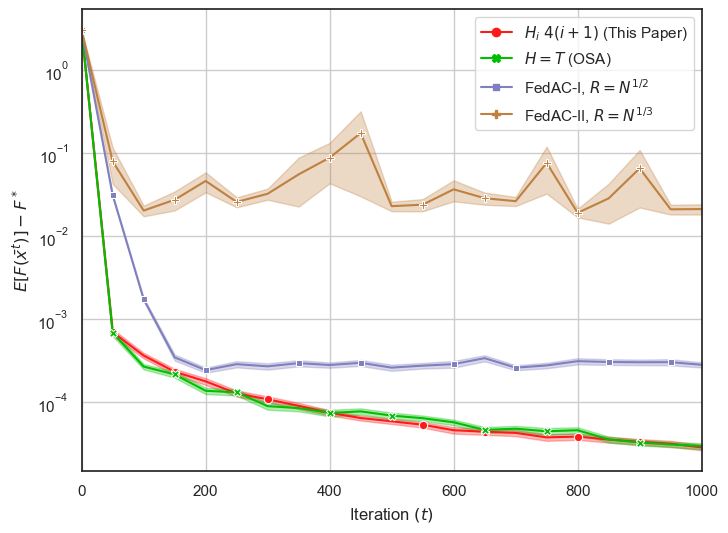

In [34]:
plot_colors = {0:(0.1, 0.1, 1),
               1:'purple',
               2:'brown',
               3:(1, 0.1, 0.1),
               4:(1,.5,0.1),
               5:(0,.75,0),
               6:(0.5,0.5,0.75),
               7:(0.75,0.5,0.25),
              }

plt.figure(figsize=(8,6))

ax = sns.lineplot(x = 'iter', y= 'error', data = iter_df,
                  hue = 'method', palette = plot_colors,
                  style = 'method',  markers = True, dashes = False, markevery=.1)

plt.gca().set_prop_cycle(None)
for m in methods:
    iter_std = iter_std_dict[m]
    plt.fill_between(
        arg.plot_every*np.arange(len(iter_std)),
        (iter_avg_dict[m] - iter_std),
        (iter_avg_dict[m] + iter_std),
        alpha=0.3,
        color = plot_colors[m],
    )

plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.xlabel(r'Iteration $(t)$')
plt.ylabel(r'$E[F(\bar x^t)] - F^*$')

plt.xlim([0,1000])
# plt.ylim([2e-15, 1e-8])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[plot_labels[int(m)] for m in labels])

plt.savefig('figures/iteration_skewed.png', dpi=240, transparent=False, bbox_inches='tight')
plt.show()

## Communication Error

In [21]:
# Combining the outputs in one dataframe for Seaborn
errors = []
comms = []
methods_list = []
for m in methods:
    errors = np.append(errors, comm_dict[m])
    comms = np.append(comms, np.arange(len(comm_dict[m])))
    methods_list += [m]*len(comm_dict[m])

comm_df = pd.DataFrame({'comm': comms, 'error': errors, 'method': methods_list})
comm_df.head()

,comm,error,method
0,0.0,3.000000,6
1,1.0,0.000288,6
2,2.0,0.000260,6
3,3.0,0.000303,6
4,4.0,0.000276,6


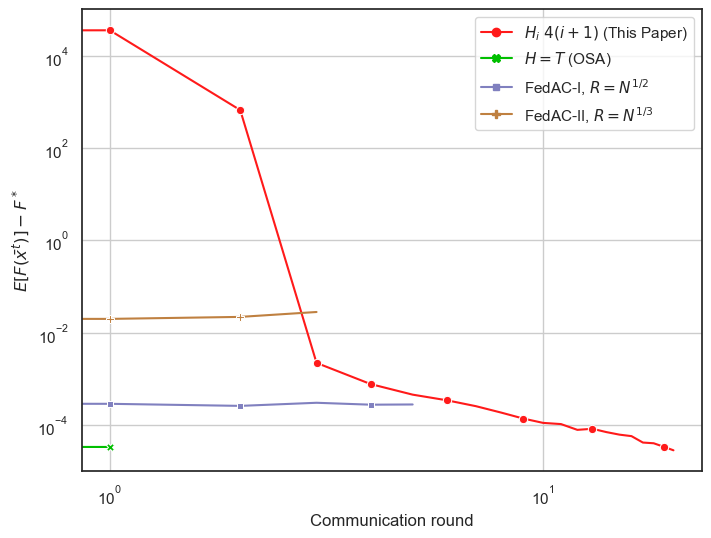

In [23]:
plt.figure(figsize=(8,6))
ax = sns.lineplot(x = 'comm', y= 'error', data = comm_df,
                  hue = 'method', palette = plot_colors ,
                  style = 'method',  markers = True, dashes = False, markevery=.1)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel(r'Communication round')
plt.ylabel(r'$E[F(\bar x^t)] - F^*$')
# plt.ylim([2e-15, 1e-8])
# plt.xlim([0,1100])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[plot_labels[int(m)] for m in labels])
plt.savefig('figures/communication_skewed.png', dpi=240, transparent=False, bbox_inches='tight')
plt.show()